In [127]:
import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import (Conv2D,Conv3D, MaxPooling2D, MaxPooling3D, Activation, 
                          Flatten, Dense, Dropout, BatchNormalization)
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import time
import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16


total unique labels 61
61
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60]
(3726, 61)


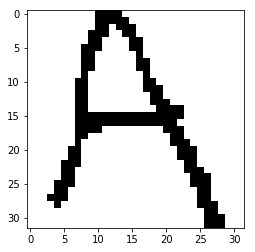

In [128]:
x_path = './alpha_numeric_dataset/alphanum-hasy-data-X.npy'
y_path = './alpha_numeric_dataset/alphanum-hasy-data-Y.npy'
x = np.load(x_path)
y = np.load(y_path)
print('total unique labels', len(np.unique(y)))
x_og = x
num_classes = len(np.unique(y))
# convert labels to be zero-based
for i in range(31, 57):
    y[y == i] -= 31
for i in range(70, 80):
    y[y == i] -= 44
for i in range(90, 109):
    y[y == i] -= 54
for i in range(110, 116):
    y[y == i] -= 55
    
x = x.reshape(x.shape[0], 32, 32 , 1)
x = np.squeeze(np.stack((x,) * 3, -1)) # convert to RGB


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                     random_state=0)

plt.imshow(x[3], interpolation='nearest')
print(len(np.unique(y_train)))
print(np.unique(y_train))

y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)
print(y_train.shape)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train/=255
x_test/=255

In [5]:
# save original images for reference
# for img, name in zip(x_og, y):
#     plt.imsave(f'./hasy-alphanum/img/{name}', img) 


In [129]:
gen = ImageDataGenerator(rotation_range=10)
train_batch = gen.flow(x_train, y_train, batch_size=128)
test_batch = gen.flow(x_test, y_test, batch_size=128)
# train_batch = ImageDataGenerator.flow(X, y_train, batch_size=64)
# single_img = next(train_batch)
# print(single_img[0].shape)
# print(single_img[1][0].shape)
# print(np.where(single_img[1][0] == 1)[0])
# single_img = single_img[0].reshape(single_img[0].shape[0], 32, 32)
# print(single_img.shape)
# plt.imshow(single_img[0])
# print(len(x_train))


In [130]:
# build model
print(x_train.ndim)
print(x_train.shape[1:])
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(61))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), 
              metrics=['accuracy'])
model.summary()

4
(32, 32, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_93 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
activation_94 (Activation)   (None, 12, 12, 64)        0      

In [69]:
# Train
start_time = time.time()
history = model.fit_generator(train_batch, steps_per_epoch=len(x_train)//64, 
                       epochs=150,
                    validation_data=test_batch, 
                    validation_steps=len(x_test)//64)
elapsed_time = time.time() - start_time
print(f'{elapsed_time:.2f} seconds')


Epoch 1/150
58/58 [==============================] - 15s 252ms/step - loss: 1.8681 - acc: 0.4252 - val_loss: 1.2815 - val_acc: 0.5690
Epoch 2/150
58/58 [==============================] - 16s 268ms/step - loss: 1.6799 - acc: 0.4678 - val_loss: 1.1630 - val_acc: 0.6024
Epoch 3/150
58/58 [==============================] - 16s 277ms/step - loss: 1.5780 - acc: 0.5049 - val_loss: 1.0423 - val_acc: 0.6244
Epoch 4/150
58/58 [==============================] - 17s 290ms/step - loss: 1.5011 - acc: 0.5201 - val_loss: 0.9627 - val_acc: 0.6810
Epoch 5/150
58/58 [==============================] - 17s 296ms/step - loss: 1.3914 - acc: 0.5404 - val_loss: 0.9181 - val_acc: 0.6567
Epoch 6/150
58/58 [==============================] - 16s 273ms/step - loss: 1.3392 - acc: 0.5567 - val_loss: 0.9621 - val_acc: 0.6459
Epoch 7/150
58/58 [==============================] - 17s 285ms/step - loss: 1.2613 - acc: 0.5763 - val_loss: 0.8618 - val_acc: 0.6922
Epoch 8/150
58/58 [==============================] - 17s 294ms

Epoch 62/150
58/58 [==============================] - 16s 278ms/step - loss: 0.5424 - acc: 0.7845 - val_loss: 0.5617 - val_acc: 0.7771
Epoch 63/150
58/58 [==============================] - 16s 277ms/step - loss: 0.5169 - acc: 0.7938 - val_loss: 0.5920 - val_acc: 0.7836
Epoch 64/150
58/58 [==============================] - 17s 284ms/step - loss: 0.5231 - acc: 0.7899 - val_loss: 0.5467 - val_acc: 0.7817
Epoch 65/150
58/58 [==============================] - 16s 281ms/step - loss: 0.5394 - acc: 0.7856 - val_loss: 0.5417 - val_acc: 0.7923
Epoch 66/150
58/58 [==============================] - 16s 281ms/step - loss: 0.5437 - acc: 0.7799 - val_loss: 0.5800 - val_acc: 0.7706
Epoch 67/150
58/58 [==============================] - 16s 282ms/step - loss: 0.5192 - acc: 0.7902 - val_loss: 0.5709 - val_acc: 0.8004
Epoch 68/150
58/58 [==============================] - 16s 284ms/step - loss: 0.5401 - acc: 0.7908 - val_loss: 0.5703 - val_acc: 0.7631
Epoch 69/150
58/58 [==============================] - 1

58/58 [==============================] - 16s 271ms/step - loss: 0.3944 - acc: 0.8327 - val_loss: 0.5585 - val_acc: 0.8053
Epoch 123/150
58/58 [==============================] - 15s 259ms/step - loss: 0.4181 - acc: 0.8275 - val_loss: 0.5519 - val_acc: 0.8072
Epoch 124/150
58/58 [==============================] - 15s 258ms/step - loss: 0.3976 - acc: 0.8330 - val_loss: 0.5564 - val_acc: 0.8085
Epoch 125/150
58/58 [==============================] - 15s 257ms/step - loss: 0.3831 - acc: 0.8357 - val_loss: 0.5270 - val_acc: 0.8109
Epoch 126/150
58/58 [==============================] - 15s 260ms/step - loss: 0.4162 - acc: 0.8283 - val_loss: 0.5682 - val_acc: 0.8141
Epoch 127/150
58/58 [==============================] - 15s 267ms/step - loss: 0.4020 - acc: 0.8329 - val_loss: 0.6193 - val_acc: 0.7935
Epoch 128/150
58/58 [==============================] - 16s 271ms/step - loss: 0.4124 - acc: 0.8317 - val_loss: 0.5982 - val_acc: 0.7749
Epoch 129/150
58/58 [==============================] - 16s 270

In [ ]:
# plot history
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
# prediction
model.save('alpha_numeric.h5')
index = 5
prediction = model.predict(x_test)
plt.imshow(x_test[index].reshape(32,32))
print(prediction[index])
print(np.argmax(prediction[index]))

In [134]:
# VGG19
from keras.applications.vgg19 import VGG19
#convert 28x28 grayscale to 48x48 rgb channels
vgg19_model = VGG19(include_top=False, input_shape=(32,32,3))
vgg19_model2 = VGG19()
vgg19_model2.summary()
# vgg19_model.summary()
# vgg19_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [135]:
our_model = Sequential()

for layer in vgg19_model.layers:
    our_model.add(layer)
for layer in our_model.layers:
    layer.trainable = False



our_model.add(Flatten())
our_model.add(Dropout(0.5))
our_model.add(Dense(4096))
our_model.add(Activation('relu'))

our_model.add(Dropout(0.5))
our_model.add(Dense(2048))
our_model.add(Activation('relu'))
our_model.add(Dropout(0.2))
our_model.add(Dense(61))
our_model.add(Activation('softmax'))


our_model.summary()

our_model.compile(loss='categorical_crossentropy', optimizer=Adam(), 
              metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)         295168    
__________

In [136]:
history = our_model.fit_generator(train_batch, steps_per_epoch=len(x_train)
                                                               //128, 
                       epochs=150,
                    validation_data=test_batch, 
                    validation_steps=len(x_test)//128)


Epoch 1/150
29/29 [==============================] - 38s 1s/step - loss: 3.5491 - acc: 0.1623 - val_loss: 2.4381 - val_acc: 0.3682
Epoch 2/150
29/29 [==============================] - 37s 1s/step - loss: 2.2438 - acc: 0.3634 - val_loss: 1.7392 - val_acc: 0.5137
Epoch 3/150
29/29 [==============================] - 38s 1s/step - loss: 1.9008 - acc: 0.4414 - val_loss: 1.4402 - val_acc: 0.5933
Epoch 4/150
29/29 [==============================] - 37s 1s/step - loss: 1.6592 - acc: 0.4940 - val_loss: 1.3497 - val_acc: 0.6206
Epoch 5/150
29/29 [==============================] - 38s 1s/step - loss: 1.5494 - acc: 0.5262 - val_loss: 1.2464 - val_acc: 0.6393
Epoch 6/150
29/29 [==============================] - 40s 1s/step - loss: 1.4767 - acc: 0.5398 - val_loss: 1.2323 - val_acc: 0.6343
Epoch 7/150
29/29 [==============================] - 46s 2s/step - loss: 1.4243 - acc: 0.5568 - val_loss: 1.1187 - val_acc: 0.6468
Epoch 8/150
29/29 [==============================] - 55s 2s/step - loss: 1.3418 - a

KeyboardInterrupt: 

In [ ]:
# plot history
from sklearn.metrics import confusion_matrix

our_model.save('VGG19_Model.h5')
result = our_model.evaluate_generator(test_batch, steps=len(x_test)//128)
test_img, test_label = next(test_batch)
test_label = test_label[:,0]

predictions = our_model.predict_generator(test_batch, steps=1)

# cm = confusion_matrix(test_label, np.round(predictions[:,0]))

print(result)

our_model.save('vgg19_model.h5')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


In [137]:
# MNIST model
from keras.datasets import mnist
batch_size = 128
num_classes = 10
img_rows, img_cols = 28, 28

(x_train2, y_train2), (x_test2, y_test2) = mnist.load_data()
x_train2 = x_train2.reshape(x_train2.shape[0], img_rows, img_cols, 1)
x_test2 = x_test2.reshape(x_test2.shape[0], img_rows, img_cols, 1)
input_shape2 = (img_rows, img_cols, 1)

x_train2 = x_train2.astype('float32')
x_test2 = x_test2.astype('float32')
x_train2 /= 255
x_test2 /= 255
print('x_train shape:', x_train2.shape)
print(x_train2.shape[0], 'train samples')
print(x_test2.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [138]:
y_train2 = keras.utils.to_categorical(y_train2, num_classes)
y_test2 = keras.utils.to_categorical(y_test2, num_classes)
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape2))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))
model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_93 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_45 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_97 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_94 (Dropout)         (None, 128)               0         
__________

In [145]:
model2.fit(x_train2, y_train2,
           batch_size=batch_size,
          epochs=5,
          verbose=1,
          validation_data=(x_test2, y_test2))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 96s 2ms/step - loss: 0.0871 - acc: 0.9745 - val_loss: 0.0420 - val_acc: 0.9860
Epoch 2/5
60000/60000 [==============================] - 99s 2ms/step - loss: 0.0652 - acc: 0.9808 - val_loss: 0.0351 - val_acc: 0.9888
Epoch 3/5
60000/60000 [==============================] - 97s 2ms/step - loss: 0.0530 - acc: 0.9838 - val_loss: 0.0343 - val_acc: 0.9888
Epoch 4/5
60000/60000 [==============================] - 99s 2ms/step - loss: 0.0463 - acc: 0.9862 - val_loss: 0.0305 - val_acc: 0.9899
Epoch 5/5
60000/60000 [==============================] - 100s 2ms/step - loss: 0.0399 - acc: 0.9879 - val_loss: 0.0295 - val_acc: 0.9906


In [146]:
model2.save('mnist.h5')